# Tumor Detection

**Acknowledgements**

(This project drew inspiration from the following resources:)

- https://www.kaggle.com/code/shtrausslearning/pytorch-cnn-binary-image-classification
- https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

**Import Libraries**

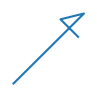

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=[1,1])
plt.axis('off')
plt.plot([-1, 2, 1, 1.75], [-1, 2, 1.75, 1])

In [100]:
import torch
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import kagglehub
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, classification_report

# Dataset

**Load and Format Dataset into DataLoader**

In [4]:
# Download dataset
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
# See what's there
print("Path to dataset files:", path)
print("Files in path:", os.listdir(path))

Path to dataset files: C:\Users\icthr\.cache\kagglehub\datasets\navoneel\brain-mri-images-for-brain-tumor-detection\versions\1
Files in path: ['brain_tumor_dataset', 'no', 'yes']


In [5]:
# load via ImageFolder
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#Normally we would just use path, but the dataset had a duplicate  
dataset = datasets.ImageFolder(root='C:/Users/icthr/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1/brain_tumor_dataset', transform=transform)

In [63]:
# Determine sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Dataset size= {dataset_size}")
print(f"Train Dataset size= {train_size}")
print(f"Validation Dataset size= {val_size}")

Dataset size= 253
Train Dataset size= 202
Validation Dataset size= 51


In [7]:
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)

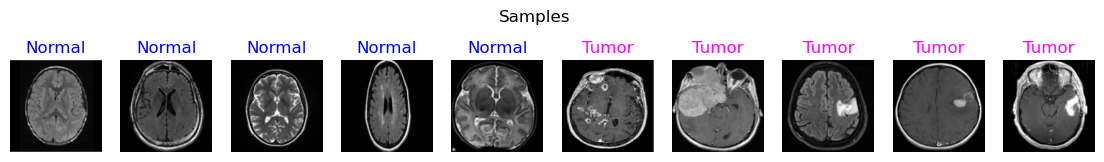

In [116]:
#Plotting 5 non-tumor and 5 tumor
tumor = 0
no_tumor = 0
count=0

plt.figure(figsize=(14, 2))
plt.suptitle('Samples')

#loop through the loader
for x_test, y_test in train_loader:
    
    y_test = y_test.view(-1, 1).float() 
    
    #loop through the batches in the loader
    for image, label in zip(x_test, y_test):
        has_tumor = label == 1
        if has_tumor and tumor < 5: #if the sample is predicted correctly & we don't have them all plotted yet, plot it. 
            tumor += 1
            sub_location=11-tumor
            title='Tumor'
        elif not has_tumor and no_tumor < 5: #if the sample is predicted incorrectly & we don't have them all plotted yet, plot it. 
            no_tumor += 1
            sub_location=no_tumor
            title='Normal'
        else:
            continue  # Skip this loop if we've reached the quota

        # Display image
        plt.subplot(1, 10, sub_location)
        plt.imshow(image[0], cmap='gray')
        title_color = 'magenta' if has_tumor else 'blue'
        plt.title(title, color=title_color)
        plt.axis('off')
        count += 1

        if count == 10:
            break
    if count == 10:
        break

**Function for finding image shapes after convolusion and maxpooling**

In [8]:
# Aquired from: 
# Andrey Shtrauss – https://www.kaggle.com/code/shtrausslearning/pytorch-cnn-binary-image-classification
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

# Model and Training

**Convolutional Neural Network**

In [9]:
# Adapted from a combination of my own model and:
# Andrey Shtrauss – https://www.kaggle.com/code/shtrausslearning/pytorch-cnn-binary-image-classification
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, shape_in=[3,128,128], init_f=16, h_1=100, num_classes=1, dropout_rate=.25):
        super(Network, self).__init__()
        
        #save seperate the shape parameters for later use
        Cin,Hin,Win=shape_in
        
        # Convolution Layers
        #Each layer, we convolve, relu, maxpool, and find the size of the new image. 
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        h,w=findConv2dOutShape(Hin,Win,self.conv1, self.maxpool1.kernel_size)
        
        #And each new conv layer will be double the previous. 
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        h,w=findConv2dOutShape(h,w,self.conv2, self.maxpool2.kernel_size)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        h,w=findConv2dOutShape(h,w,self.conv3, self.maxpool3.kernel_size)
        
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        self.maxpool4=nn.MaxPool2d(kernel_size=2)
        h,w=findConv2dOutShape(h,w,self.conv4, self.maxpool4.kernel_size)
        
        # Compute the flatten size with the saved image dimensions. 
        # Including batch normalization to stabilize learning
        self.num_flatten=h*w*8*init_f
        self.bn1=nn.BatchNorm1d(self.num_flatten)
        
        #input values into hidden linear layer, Normalize output, & include dropout. 
        self.fc1 = nn.Linear(self.num_flatten, h_1)
        self.bn2=nn.BatchNorm1d(h_1)
        self.dropout = nn.Dropout(dropout_rate)

        #input values into final layer, no activation functions needed as BCEWithLogitsLoss auto includes it. 
        self.fc2 = nn.Linear(h_1, num_classes)

    def forward(self,x):
        x=self.maxpool1(torch.relu(self.conv1(x)))
        x=self.maxpool2(torch.relu(self.conv2(x)))
        x=self.maxpool3(torch.relu(self.conv3(x)))
        x=self.maxpool4(torch.relu(self.conv4(x)))
        
        x = self.bn1(x.view(-1, self.num_flatten))
        
        x = torch.relu(self.bn2(self.fc1(x)))
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

**Function to Train Model**

In [10]:
#Function for training the model
def train_model(model,train_loader,val_loader,optimizer,n_epochs=4):
    cost_list=[]
    #global variable 
    N_test=len(val_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            y=y.view(-1,1)
            y=y.float()
            #print(z,y)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)
            COST+=loss.data 
            
        cost_list.append(COST)    
        correct = 0
        total = 0
        for x_test, y_test in val_loader:
            model.eval()
            with torch.no_grad():
                test_outputs = model(x_test)
                predictions = (test_outputs > 0.5).float()
                y_test = y_test.view(-1, 1).float()
                correct += (predictions == y_test).sum().item()
                total += y_test.size(0)
                
        accuracy = correct / total
        accuracy_list.append(accuracy)
        
    return accuracy_list, loss_list, cost_list

**Initialize and Train model**

In [65]:
#calculating tumor/non_tumor distribution to alter criterion loss function. 
train_labels = torch.tensor([label for _, label in train_dataset])
# Calculate class counts
num_pos = (train_labels == 1).sum()
num_neg = (train_labels == 0).sum()
# Weight for positive class
pos_weight = torch.tensor([num_neg / num_pos])

In [14]:
# Create the model object using CNN class
model = Network(shape_in=[3,128,128], init_f=16, h_1=100, num_classes=1, dropout_rate=.25)

In [ ]:
#Train
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001, momentum=0.9)
accuracy_list, loss_list, cost_list = train_model(model,train_loader,val_loader,optimizer,n_epochs=50)

# Results

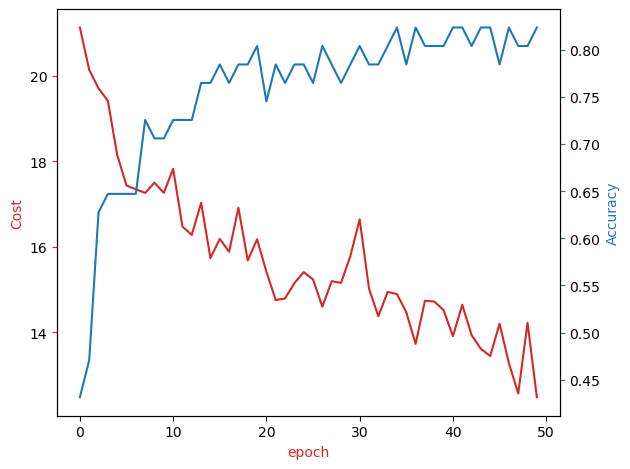

In [207]:
#Plot Accuracy & Cost
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [108]:
#Save the model
torch.save(model.state_dict(), 'Tumor_Classification.pth')

In [109]:
# Load the model
model.load_state_dict(torch.load('Tumor_Classification.pth'))
# Ensure the loaded model is in evaluation mode
model.eval()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(4608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)

In [110]:
#Run validation again to save predictions/accuracy for confusion matrix
correct = 0
total = 0
y_pred = []
y_true=[]
test_outputs_all=[]
for x_test, y_test in val_loader:
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        predictions = (test_outputs > 0.5).float()
        y_test = y_test.view(-1, 1).float()
        correct += (predictions == y_test).sum().item()
        total += y_test.size(0)
        for pred, test, outputs in zip(predictions, y_test, test_outputs):
            y_pred.append(pred.item())
            y_true.append(test.item())
            test_outputs_all.append(outputs.item())
        
accuracy = correct / total
print(f" Accuracy= {accuracy}")

 Accuracy= 0.8823529411764706


              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84        17
         1.0       0.97      0.85      0.91        34

    accuracy                           0.88        51
   macro avg       0.86      0.90      0.87        51
weighted avg       0.90      0.88      0.88        51



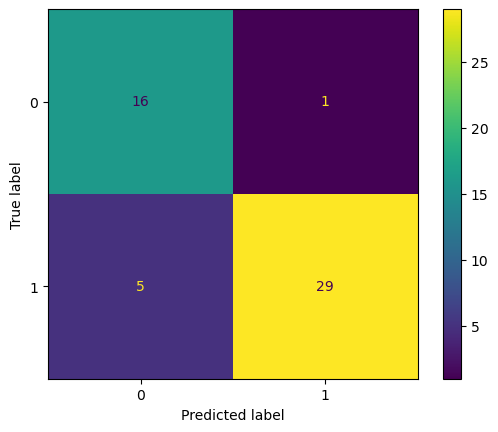

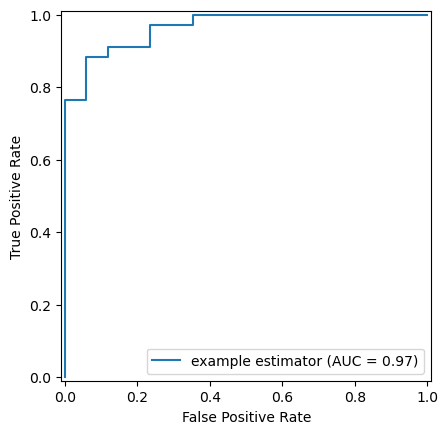

In [111]:
#Confusion Matirx, displaying true/false positives/negatives
cm = confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(cm, display_labels=None)
disp.plot()
#ROC curve and area under curve. 
y_score=test_outputs_all #the score is the value BEFORE thresholding. could also just use the test_outputs.
fpr, tpr, thresholds =roc_curve(y_true,y_score)
AreaUnderCurve=auc(fpr, tpr)
rock_curve=RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AreaUnderCurve, estimator_name='example estimator')
rock_curve.plot()
#Classification report. 
print(classification_report(y_true,y_pred))

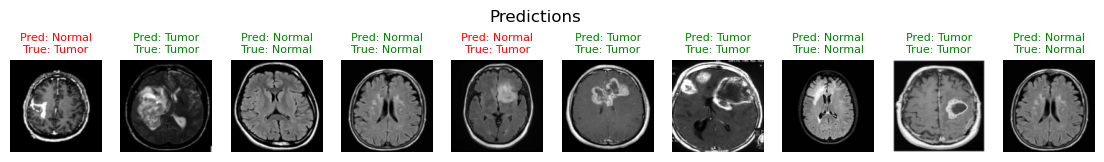

In [118]:
#Plotting 10 predictions with a correct/incorrect distribution equal to the accuracy
#Num_wrong = 10 - round(int(accuracy_list[-1] * 10))
Num_wrong = 10 - round(int(.82 * 10))
correct = 0
incorrect = 0
count = 0

plt.figure(figsize=(14, 2))
plt.suptitle('Predictions')

#loop through the loader
for x_test, y_test in val_loader:
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        predictions = (test_outputs > 0.5).float()
        y_test = y_test.view(-1, 1).float()
        
    #loop through the batches in the loader
    for image, pred, actual in zip(x_test, predictions, y_test):
        is_correct = pred.int().item() == actual.int().item()

        if is_correct and correct < (10 - Num_wrong): #if the sample is predicted correctly & we don't have them all plotted yet, plot it. 
            correct += 1
        elif not is_correct and incorrect < Num_wrong: #if the sample is predicted incorrectly & we don't have them all plotted yet, plot it. 
            incorrect += 1
        else:
            continue  # Skip this loop if we've reached the quota

        # Display image
        plt.subplot(1, 10, count + 1)
        plt.imshow(image[0], cmap='gray')
        title_color = 'green' if is_correct else 'red'
        pred_label = 'Tumor' if pred.item() == 1 else 'Normal'
        true_label = 'Tumor' if actual.item() == 1 else 'Normal'
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color, fontsize=8)
        plt.axis('off')
        count += 1

        if count == 10:
            break
    if count == 10:
        break